#📌 Extracción

In [7]:
# Importamos las bibliotecas necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import requests
import json
import warnings
warnings.filterwarnings('ignore')

# Configuración para visualizaciones
plt.style.use('fivethirtyeight')
sns.set_palette("Set2")
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Definimos la URL de la API
url_api = "https://raw.githubusercontent.com/ingridcristh/challenge2-data-science-LATAM/refs/heads/main/TelecomX_Data.json"

# Realizamos la petición a la API
print("Extrayendo datos de la API...")
response = requests.get(url_api)

# Verificamos si la petición fue exitosa
if response.status_code == 200:
    print("Conexión exitosa a la API")
    # Convertimos los datos JSON a un diccionario de Python
    data = json.loads(response.text)

    # Convertimos el diccionario a un DataFrame de pandas
    df = pd.DataFrame(data)

    print(f"Datos extraídos exitosamente. Dimensiones del DataFrame: {df.shape}")

    # Mostramos las primeras filas del DataFrame para verificar la extracción
    print("\nPrimeras 5 filas del DataFrame:")
    display(df.head())
else:
    print(f"Error al conectarse a la API. Código de estado: {response.status_code}")

# Mostramos información sobre la estructura del DataFrame
print("\nEstructura del DataFrame:")
df.info()

# Mostramos los tipos de datos de cada columna
print("\nTipos de datos por columna:")
print(df.dtypes)

Extrayendo datos de la API...
Conexión exitosa a la API
Datos extraídos exitosamente. Dimensiones del DataFrame: (7267, 6)

Primeras 5 filas del DataFrame:


,customerID,Churn,customer,phone,internet,account
0,0002-ORFBO,No,"{'gender': 'Female', 'SeniorCitizen': 0, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'One year', 'PaperlessBilling': '..."
1,0003-MKNFE,No,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'Yes'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
2,0004-TLHLJ,Yes,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
3,0011-IGKFF,Yes,"{'gender': 'Male', 'SeniorCitizen': 1, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
4,0013-EXCHZ,Yes,"{'gender': 'Female', 'SeniorCitizen': 1, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."



Estructura del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   customerID  7267 non-null   object
 1   Churn       7267 non-null   object
 2   customer    7267 non-null   object
 3   phone       7267 non-null   object
 4   internet    7267 non-null   object
 5   account     7267 non-null   object
dtypes: object(6)
memory usage: 340.8+ KB

Tipos de datos por columna:
customerID    object
Churn         object
customer      object
phone         object
internet      object
account       object
dtype: object


#🔧 Transformación

In [8]:
# 2.1 Análisis inicial de datos y detección de problemas

# Flatten the nested dictionaries into new columns
df_flat = pd.json_normalize(data)

# Now use the flattened DataFrame for further processing
# Verificamos valores nulos en el DataFrame
print("Cantidad de valores nulos por columna:")
print(df_flat.isnull().sum())

# Verificamos valores duplicados
duplicados = df_flat.duplicated().sum()
print(f"\nCantidad de filas duplicadas: {duplicados}")

# Analizamos valores únicos en columnas categóricas
print("\nValores únicos en columnas categóricas:")
for columna in df_flat.select_dtypes(include=['object']).columns:
    print(f"{columna}: {df_flat[columna].unique()}")

# 2.2 Limpieza y transformación de datos

# Creamos una copia del DataFrame para no modificar el original
df_clean = df_flat.copy()

# Convertimos SeniorCitizen de numérico (0/1) a categórico (No/Sí)
df_clean['customer.SeniorCitizen'] = df_clean['customer.SeniorCitizen'].map({0: 'No', 1: 'Si'})

# Transformamos los valores de las columnas categóricas
# Para estandarizar y facilitar el análisis
binary_columns = ['customer.Partner', 'customer.Dependents', 'phone.PhoneService', 'account.PaperlessBilling', 'Churn']
for col in binary_columns:
    df_clean[col] = df_clean[col].map({'Yes': 'Si', 'No': 'No'})

# Transformamos las columnas de servicios con valores 'No phone service' o 'No internet service'
service_columns = ['phone.MultipleLines', 'internet.OnlineSecurity', 'internet.OnlineBackup', 'internet.DeviceProtection', 'internet.TechSupport', 'internet.StreamingTV', 'internet.StreamingMovies']
for col in service_columns:
    df_clean[col] = df_clean[col].replace({'No phone service': 'No', 'No internet service': 'No'})
    df_clean[col] = df_clean[col].map({'Yes': 'Si', 'No': 'No'})

# Verificamos la existencia de valores inconsistentes en la columna 'tenure'
print("\nEstadísticas de la columna tenure:")
print(df_clean['customer.tenure'].describe())

# Verificamos la existencia de valores inconsistentes en las columnas de cargos
print("\nEstadísticas de la columna Charges.Monthly:")
print(df_clean['account.Charges.Monthly'].describe())

print("\nEstadísticas de la columna Charges.Total:")
print(df_clean['account.Charges.Total'].describe())

# Convert 'account.Charges.Total' to numeric, coercing errors
df_clean['account.Charges.Total'] = pd.to_numeric(df_clean['account.Charges.Total'], errors='coerce')

# Fill missing 'account.Charges.Total' with 0
df_clean['account.Charges.Total'] = df_clean['account.Charges.Total'].fillna(0)


# 2.3 Creación de nuevas variables

# Creamos la columna 'Cuentas_Diarias' dividiendo los cargos mensuales por 30
df_clean['Cuentas_Diarias'] = df_clean['account.Charges.Monthly'] / 30
print("\nEstadísticas de la nueva columna Cuentas_Diarias:")
print(df_clean['Cuentas_Diarias'].describe())

# Creamos una columna con la cantidad de servicios contratados por cliente
servicio_columnas = ['phone.PhoneService', 'phone.MultipleLines', 'internet.OnlineSecurity', 'internet.OnlineBackup',
                   'internet.DeviceProtection', 'internet.TechSupport', 'internet.StreamingTV', 'internet.StreamingMovies']

# Inicializamos la columna de servicios contratados con 0
df_clean['CantidadServicios'] = 0

# Sumamos 1 por cada servicio contratado (valor = 'Si')
for col in servicio_columnas:
    df_clean['CantidadServicios'] += (df_clean[col] == 'Si').astype(int)

print("\nEstadísticas de la nueva columna CantidadServicios:")
print(df_clean['CantidadServicios'].describe())

# Creamos categorías de antigüedad del cliente
bins = [0, 12, 24, 36, 48, 60, 72]
labels = ['0-12 meses', '13-24 meses', '25-36 meses', '37-48 meses', '49-60 meses', '61-72 meses']
df_clean['CategoriaAntiguedad'] = pd.cut(df_clean['customer.tenure'], bins=bins, labels=labels, right=True)

print("\nDistribución de clientes por categoría de antigüedad:")
print(df_clean['CategoriaAntiguedad'].value_counts())

# 2.4 Codificación de variables categóricas para análisis estadístico
# Creamos una copia para análisis numéricos
df_numeric = df_clean.copy()

# Codificamos las variables binarias
binary_columns = ['customer.Partner', 'customer.Dependents', 'phone.PhoneService', 'phone.MultipleLines', 'internet.OnlineSecurity',
                 'internet.OnlineBackup', 'internet.DeviceProtection', 'internet.TechSupport', 'internet.StreamingTV',
                 'internet.StreamingMovies', 'account.PaperlessBilling', 'Churn', 'customer.SeniorCitizen']

for col in binary_columns:
    df_numeric[col] = df_numeric[col].map({'Si': 1, 'No': 0})

# Codificamos 'gender' usando dummy variables
df_numeric = pd.get_dummies(df_numeric, columns=['customer.gender'], drop_first=True)

# Codificamos 'Contract' usando dummy variables
df_numeric = pd.get_dummies(df_numeric, columns=['account.Contract'], drop_first=True)

# Codificamos 'PaymentMethod' usando dummy variables
df_numeric = pd.get_dummies(df_numeric, columns=['account.PaymentMethod'], drop_first=True)

# Codificamos 'InternetService' usando dummy variables
df_numeric = pd.get_dummies(df_numeric, columns=['internet.InternetService'], drop_first=True)

# Revisamos el DataFrame con las nuevas columnas codificadas
print("\nColumnas del DataFrame numérico:")
print(df_numeric.columns.tolist())

# Verificamos que no haya valores nulos después de las transformaciones
print("\nCantidad de valores nulos en el DataFrame transformado:")
print(df_numeric.isnull().sum().sum())

# Mostramos las primeras filas del DataFrame transformado
print("\nPrimeras filas del DataFrame transformado:")
display(df_clean.head())

Cantidad de valores nulos por columna:
customerID                   0
Churn                        0
customer.gender              0
customer.SeniorCitizen       0
customer.Partner             0
customer.Dependents          0
customer.tenure              0
phone.PhoneService           0
phone.MultipleLines          0
internet.InternetService     0
internet.OnlineSecurity      0
internet.OnlineBackup        0
internet.DeviceProtection    0
internet.TechSupport         0
internet.StreamingTV         0
internet.StreamingMovies     0
account.Contract             0
account.PaperlessBilling     0
account.PaymentMethod        0
account.Charges.Monthly      0
account.Charges.Total        0
dtype: int64

Cantidad de filas duplicadas: 0

Valores únicos en columnas categóricas:
customerID: ['0002-ORFBO' '0003-MKNFE' '0004-TLHLJ' ... '9992-UJOEL' '9993-LHIEB'
 '9995-HOTOH']
Churn: ['No' 'Yes' '']
customer.gender: ['Female' 'Male']
customer.Partner: ['Yes' 'No']
customer.Dependents: ['Yes' 'No']
pho

,customerID,Churn,customer.gender,customer.SeniorCitizen,customer.Partner,customer.Dependents,customer.tenure,phone.PhoneService,phone.MultipleLines,internet.InternetService,...,internet.StreamingTV,internet.StreamingMovies,account.Contract,account.PaperlessBilling,account.PaymentMethod,account.Charges.Monthly,account.Charges.Total,Cuentas_Diarias,CantidadServicios,CategoriaAntiguedad
0,0002-ORFBO,No,Female,No,Si,Si,9,Si,No,DSL,...,Si,No,One year,Si,Mailed check,65.6,593.30,2.186667,4,0-12 meses
1,0003-MKNFE,No,Male,No,No,No,9,Si,Si,DSL,...,No,Si,Month-to-month,No,Mailed check,59.9,542.40,1.996667,3,0-12 meses
2,0004-TLHLJ,Si,Male,No,No,No,4,Si,No,Fiber optic,...,No,No,Month-to-month,Si,Electronic check,73.9,280.85,2.463333,2,0-12 meses
3,0011-IGKFF,Si,Male,Si,Si,No,13,Si,No,Fiber optic,...,Si,Si,Month-to-month,Si,Electronic check,98.0,1237.85,3.266667,5,13-24 meses
4,0013-EXCHZ,Si,Female,Si,Si,No,3,Si,No,Fiber optic,...,Si,No,Month-to-month,Si,Mailed check,83.9,267.40,2.796667,3,0-12 meses


#📊 Carga y análisis

Estadísticas descriptivas para variables numéricas:


,customer.tenure,account.Charges.Monthly,account.Charges.Total,Cuentas_Diarias,CantidadServicios
count,7267.000000,7267.000000,7267.000000,7267.000000,7267.000000
mean,32.346498,64.720098,2277.182035,2.157337,3.358745
std,24.571773,30.129572,2268.648587,1.004319,2.062729
min,0.000000,18.250000,0.000000,0.608333,0.000000
25%,9.000000,35.425000,396.200000,1.180833,1.000000
50%,29.000000,70.300000,1389.200000,2.343333,3.000000
75%,55.000000,89.875000,3778.525000,2.995833,5.000000
max,72.000000,118.750000,8684.800000,3.958333,8.000000



Distribución de clientes por estado de Churn:
Churn
No    5174
Si    1869
Name: count, dtype: int64

Porcentaje de Churn: 26.54%
Porcentaje de No Churn: 73.46%


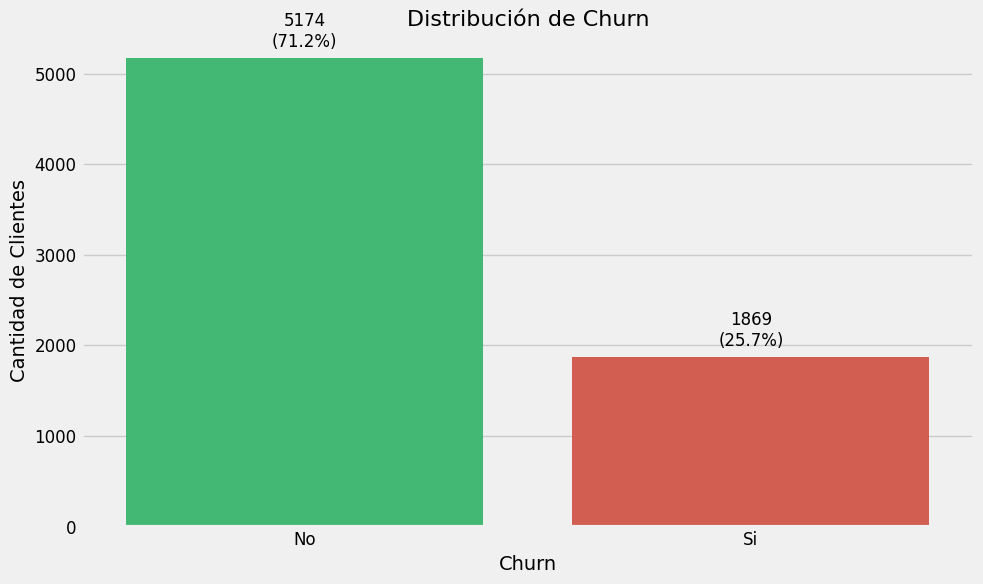

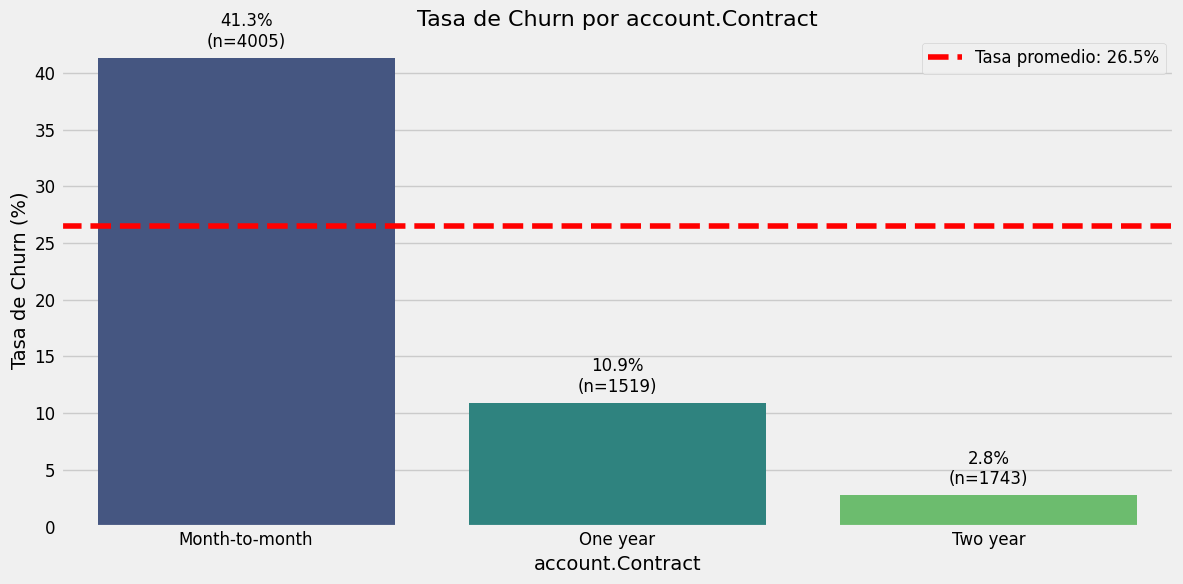


Tasa de Churn por account.Contract:


,account.Contract,Churn,Count
0,Month-to-month,41.323346,4005
1,One year,10.928242,1519
2,Two year,2.753873,1743


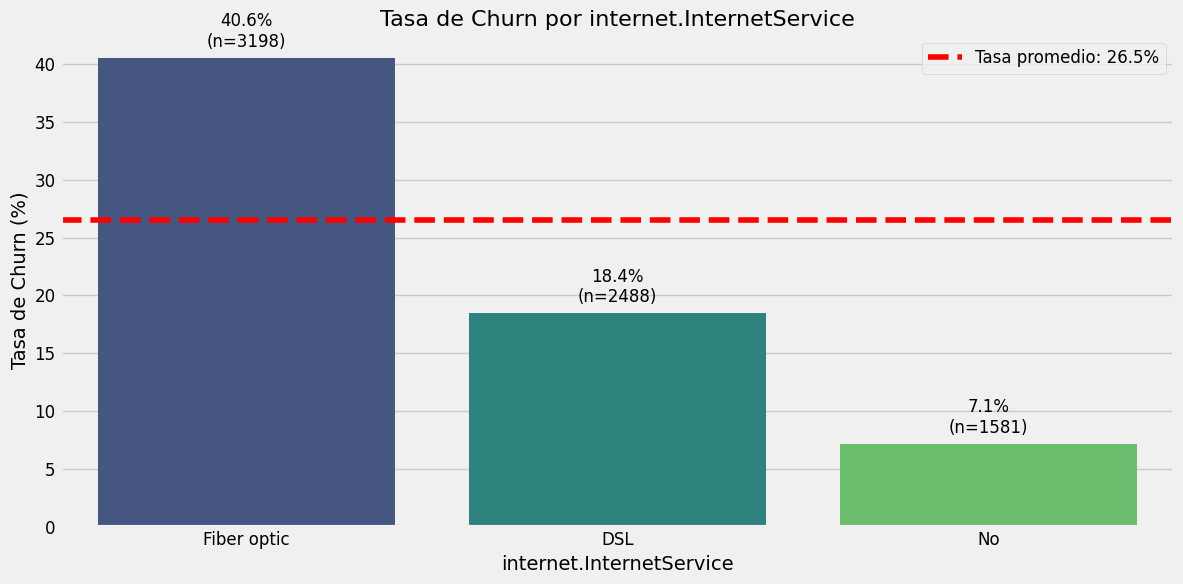


Tasa de Churn por internet.InternetService:


,internet.InternetService,Churn,Count
0,Fiber optic,40.556598,3198
1,DSL,18.448553,2488
2,No,7.147375,1581


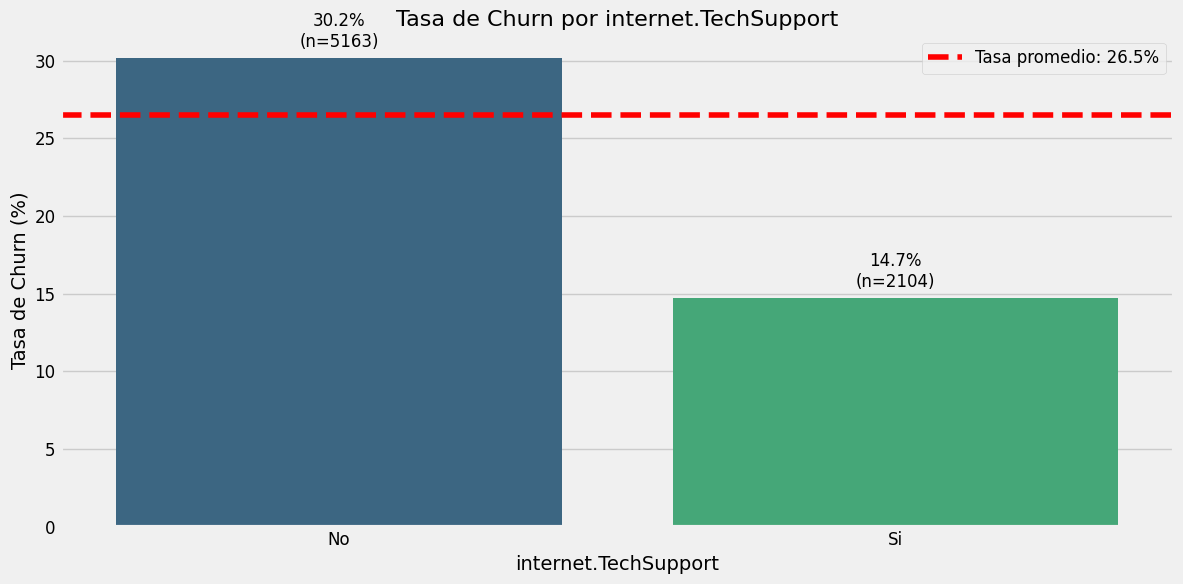


Tasa de Churn por internet.TechSupport:


,internet.TechSupport,Churn,Count
0,No,30.195623,5163
1,Si,14.733840,2104


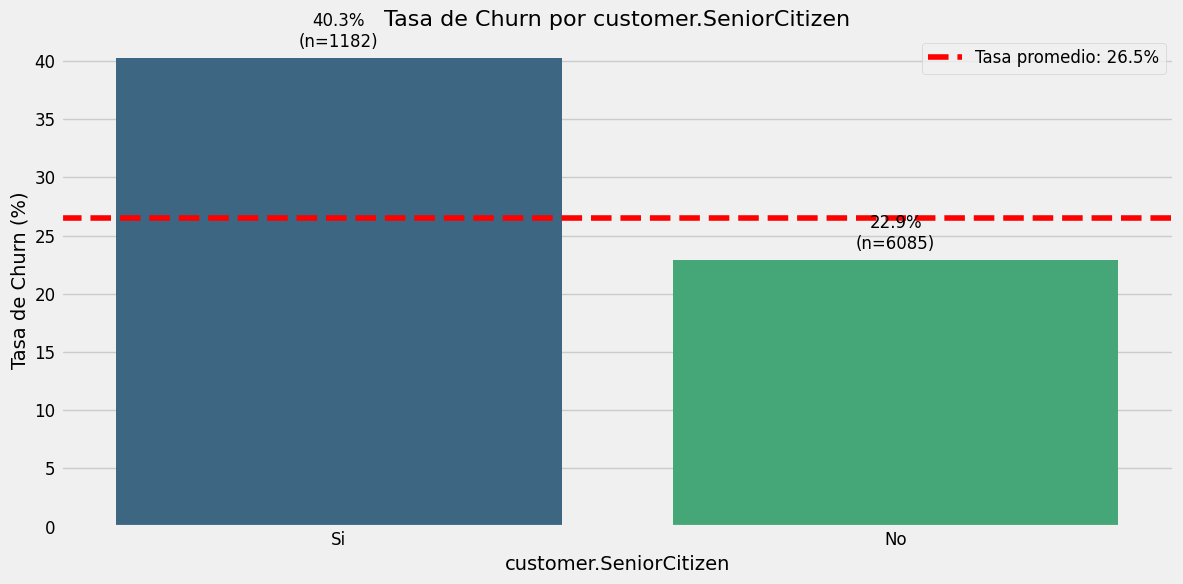


Tasa de Churn por customer.SeniorCitizen:


,customer.SeniorCitizen,Churn,Count
0,Si,40.270728,1182
1,No,22.892358,6085


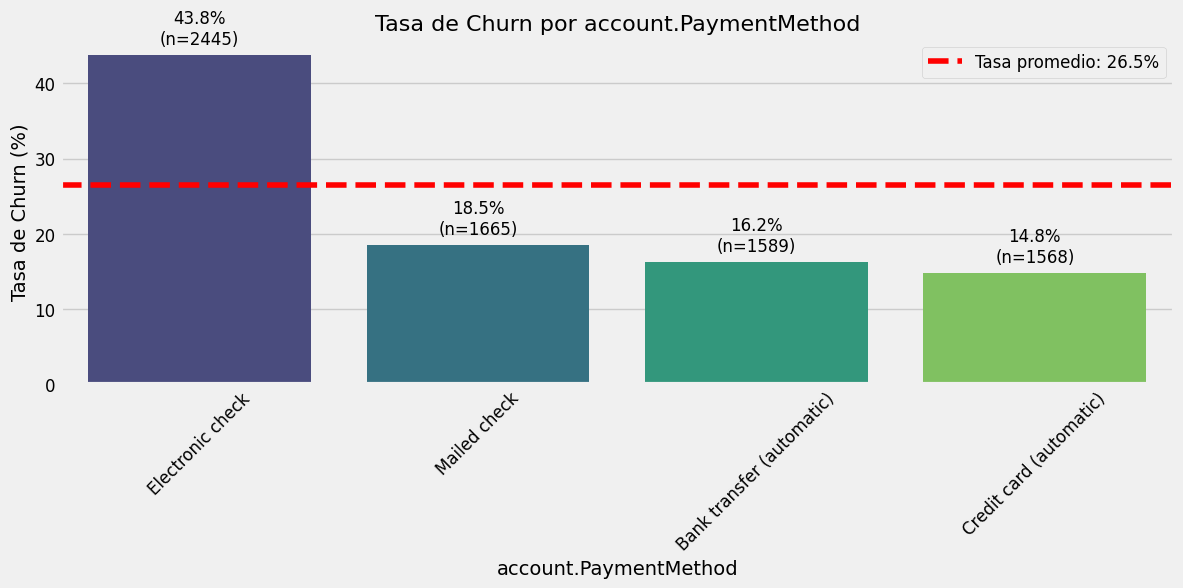


Tasa de Churn por account.PaymentMethod:


,account.PaymentMethod,Churn,Count
0,Electronic check,43.803681,2445
1,Mailed check,18.498498,1665
2,Bank transfer (automatic),16.236627,1589
3,Credit card (automatic),14.795918,1568


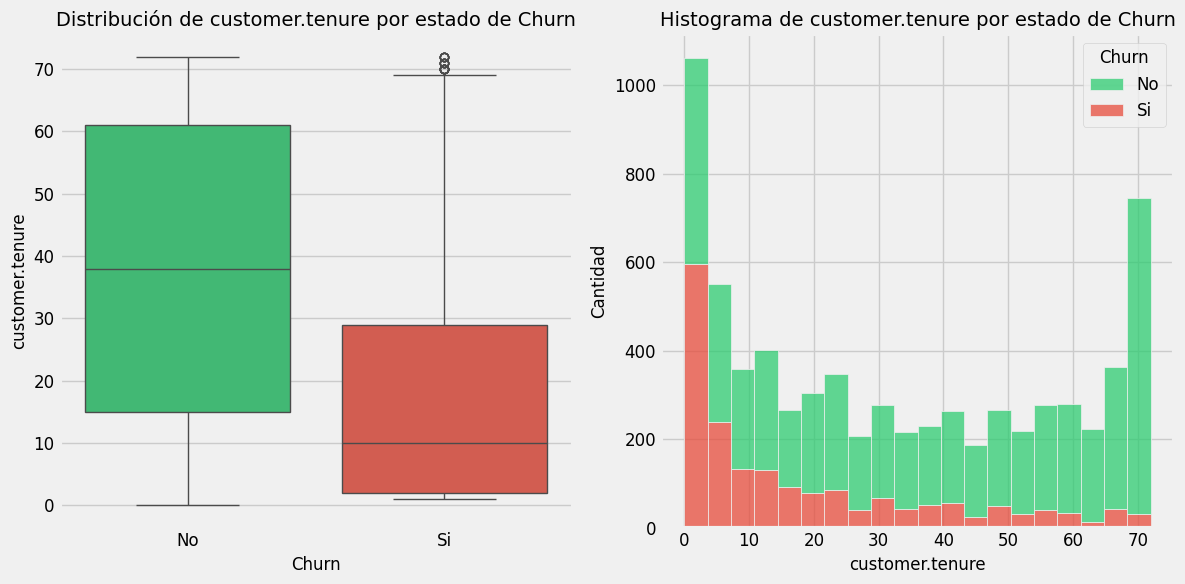


Estadísticas de customer.tenure por estado de Churn:


,count,mean,std,min,25%,50%,75%,max
Churn,,,,,,,,
No,5174.0,37.569965,24.113777,0.0,15.0,38.0,61.0,72.0
Si,1869.0,17.979133,19.531123,1.0,2.0,10.0,29.0,72.0


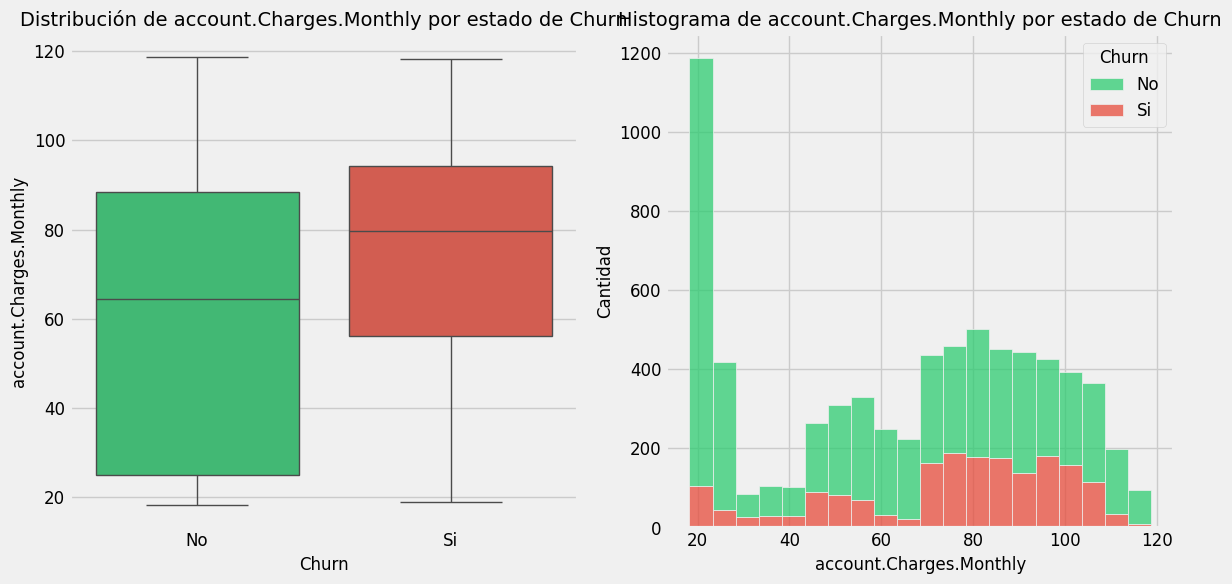


Estadísticas de account.Charges.Monthly por estado de Churn:


,count,mean,std,min,25%,50%,75%,max
Churn,,,,,,,,
No,5174.0,61.265124,31.092648,18.25,25.10,64.425,88.4,118.75
Si,1869.0,74.441332,24.666053,18.85,56.15,79.650,94.2,118.35


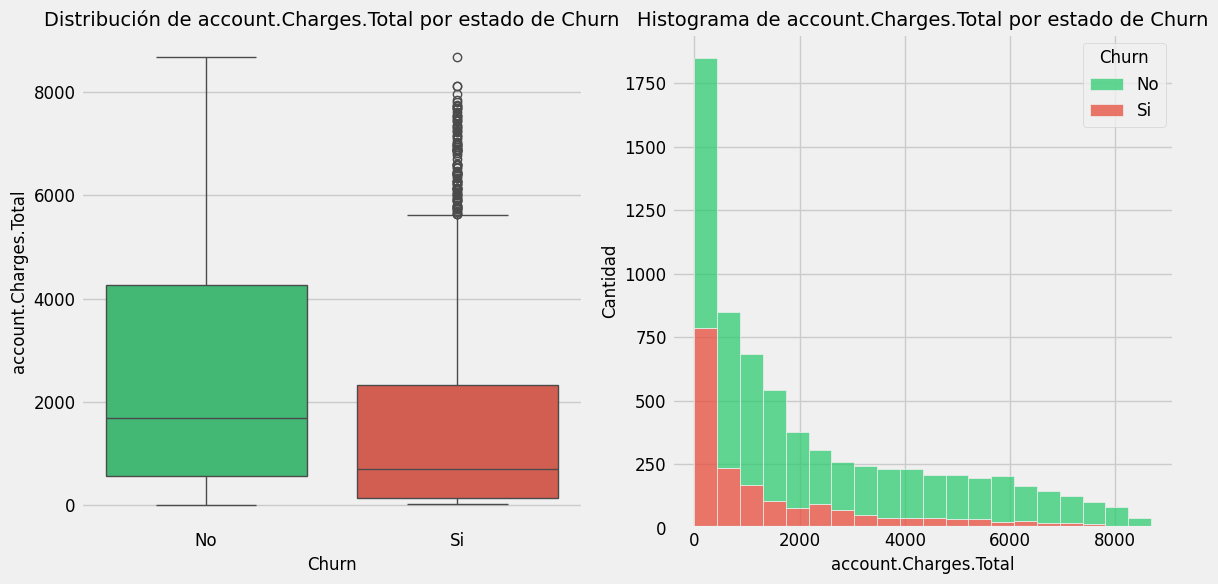


Estadísticas de account.Charges.Total por estado de Churn:


,count,mean,std,min,25%,50%,75%,max
Churn,,,,,,,,
No,5174.0,2549.911442,2329.954215,0.00,572.9,1679.525,4262.85,8672.45
Si,1869.0,1531.796094,1890.822994,18.85,134.5,703.550,2331.30,8684.80


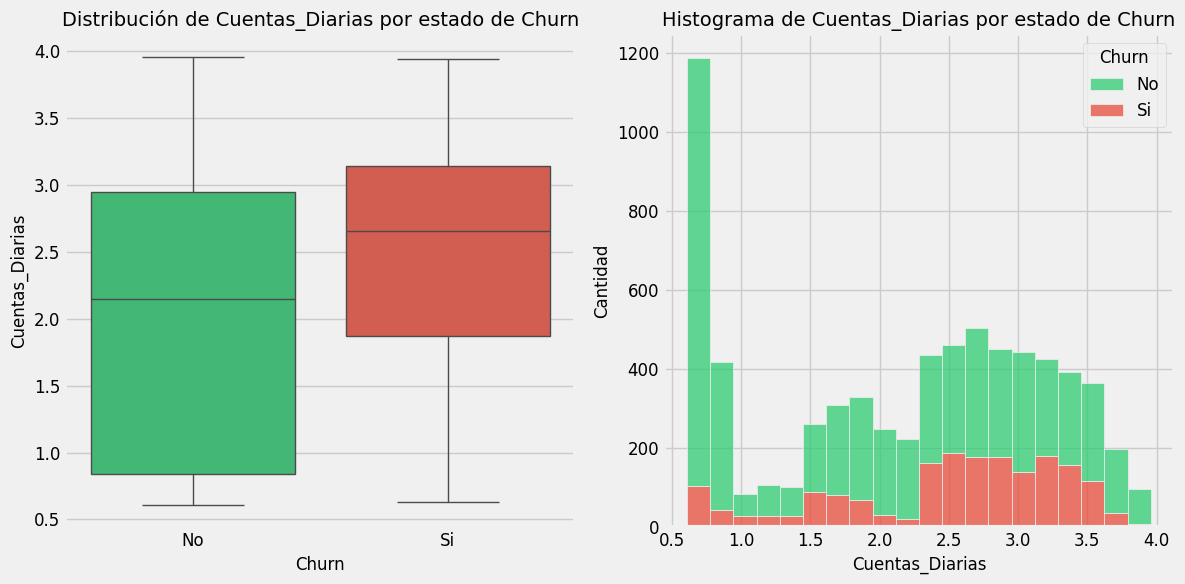


Estadísticas de Cuentas_Diarias por estado de Churn:


,count,mean,std,min,25%,50%,75%,max
Churn,,,,,,,,
No,5174.0,2.042171,1.036422,0.608333,0.836667,2.1475,2.946667,3.958333
Si,1869.0,2.481378,0.822202,0.628333,1.871667,2.6550,3.140000,3.945000


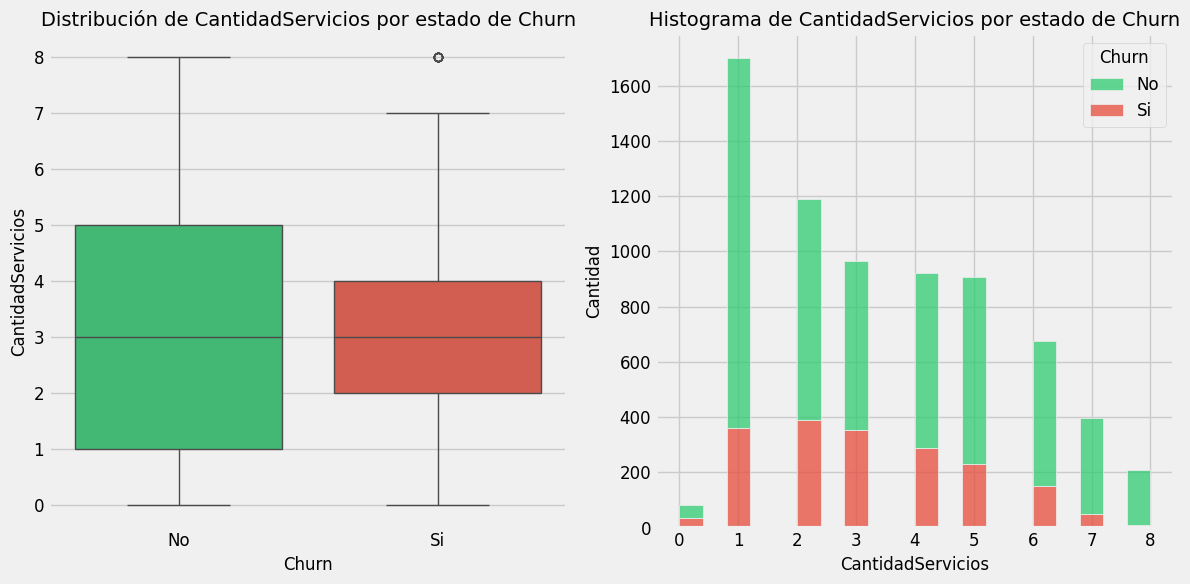


Estadísticas de CantidadServicios por estado de Churn:


,count,mean,std,min,25%,50%,75%,max
Churn,,,,,,,,
No,5174.0,3.446270,2.156391,0.0,1.0,3.0,5.0,8.0
Si,1869.0,3.132156,1.754828,0.0,2.0,3.0,4.0,8.0


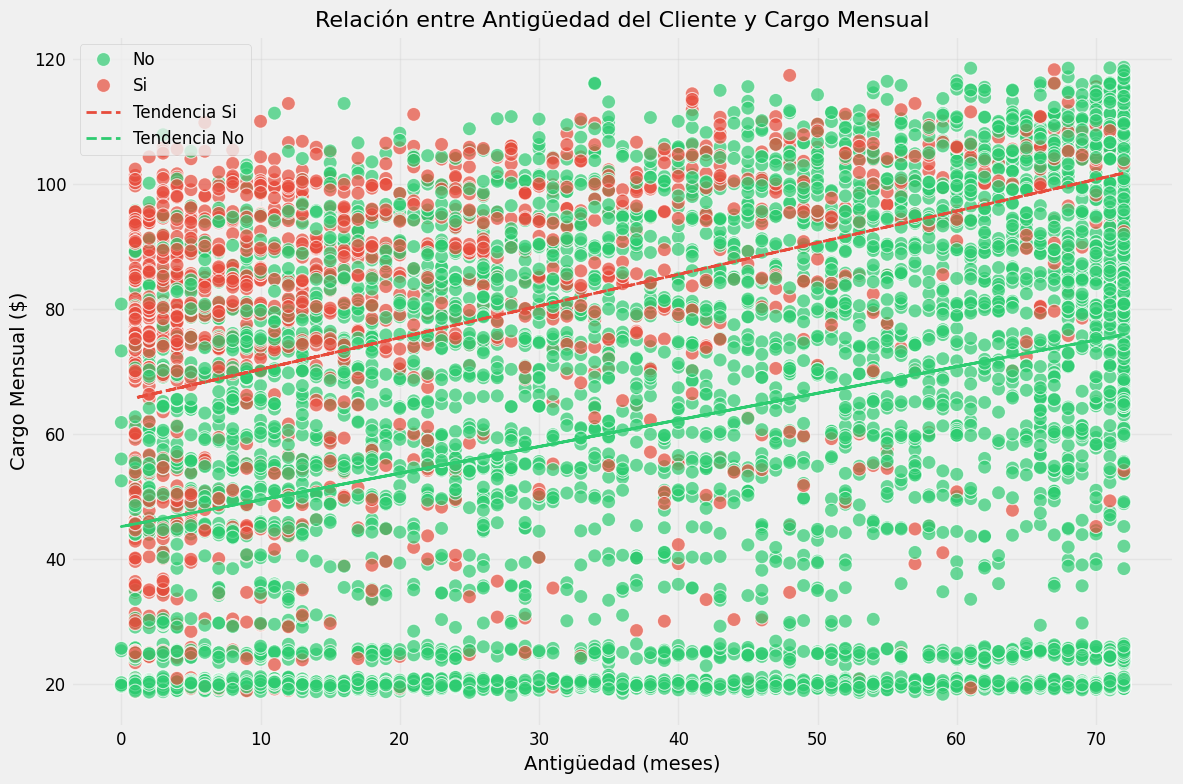

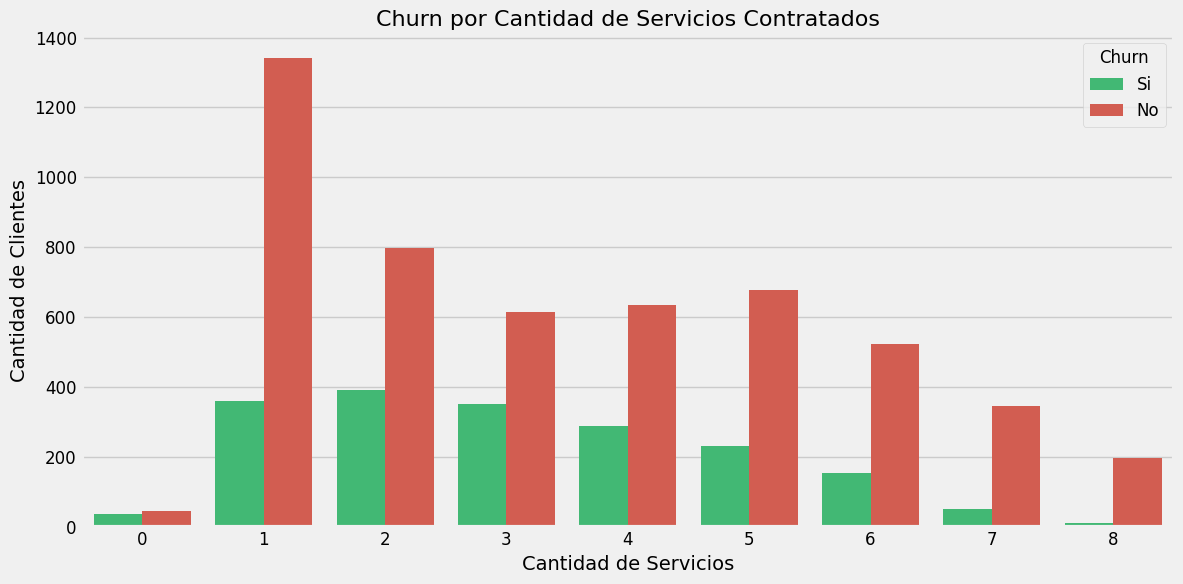


Tasa de Churn por Cantidad de Servicios:


,CantidadServicios,Churn
0,0,43.209877
1,1,20.339943
2,2,31.784841
3,3,35.412475
4,4,30.421053
5,5,24.973089
6,6,21.745351
7,7,12.009804
8,8,5.140187


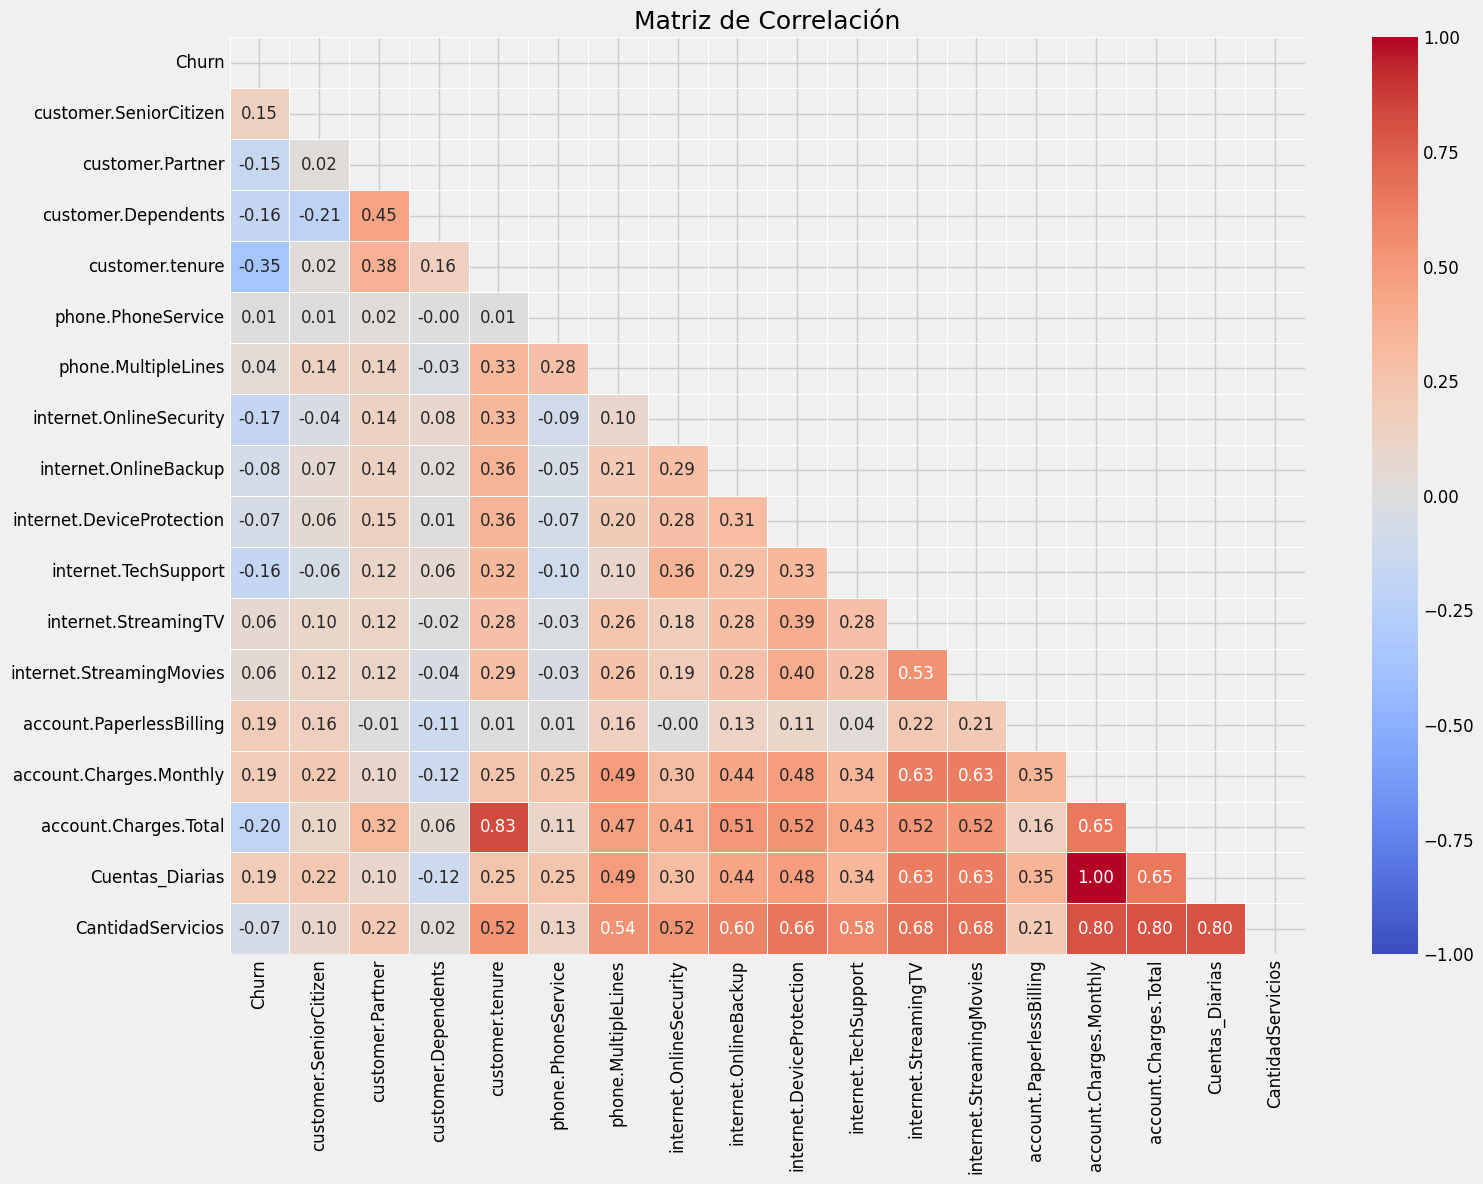


Correlaciones con Churn (ordenadas):


,Churn
Churn,1.000000
account.Charges.Monthly,0.193356
Cuentas_Diarias,0.193356
account.PaperlessBilling,0.191825
customer.SeniorCitizen,0.150889
internet.StreamingTV,0.063228
internet.StreamingMovies,0.061382
phone.MultipleLines,0.040102
phone.PhoneService,0.011942
internet.DeviceProtection,-0.066160


In [10]:
# 3.1 Análisis descriptivo básico

# Estadísticas descriptivas para variables numéricas
print("Estadísticas descriptivas para variables numéricas:")
display(df_clean[['customer.tenure', 'account.Charges.Monthly', 'account.Charges.Total', 'Cuentas_Diarias', 'CantidadServicios']].describe())

# 3.2 Análisis de distribución de Churn

# Contamos y calculamos el porcentaje de churners vs no churners
churn_count = df_clean['Churn'].value_counts()
churn_percent = df_clean['Churn'].value_counts(normalize=True) * 100

print("\nDistribución de clientes por estado de Churn:")
print(churn_count)
print(f"\nPorcentaje de Churn: {churn_percent['Si']:.2f}%")
print(f"Porcentaje de No Churn: {churn_percent['No']:.2f}%")

# Visualización de la distribución de Churn
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='Churn', data=df_clean, palette=['#2ecc71', '#e74c3c'])
plt.title('Distribución de Churn', fontsize=16)
plt.xlabel('Churn', fontsize=14)
plt.ylabel('Cantidad de Clientes', fontsize=14)

# Agregar etiquetas con los valores y porcentajes
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}\n({height/len(df_clean)*100:.1f}%)',
                (p.get_x() + p.get_width()/2., height),
                ha = 'center', va = 'bottom', xytext = (0, 5),
                textcoords = 'offset points', fontsize=12)

plt.tight_layout()
plt.show()

# 3.3 Análisis de Churn por variables categóricas

# Lista de variables categóricas para análisis
cat_vars = ['customer.gender', 'customer.SeniorCitizen', 'customer.Partner', 'customer.Dependents',
           'phone.PhoneService', 'phone.MultipleLines', 'internet.InternetService',
           'internet.OnlineSecurity', 'internet.OnlineBackup', 'internet.DeviceProtection',
           'internet.TechSupport', 'internet.StreamingTV', 'internet.StreamingMovies',
           'account.Contract', 'account.PaperlessBilling', 'account.PaymentMethod', 'CategoriaAntiguedad']

# Creamos una función para visualizar la tasa de churn por categoría
def plot_churn_by_category(df, cat_var):
    # Calculamos la tasa de churn por categoría
    churn_rate = df.groupby(cat_var)['Churn'].apply(lambda x: (x == 'Si').mean() * 100).reset_index()
    churn_rate = churn_rate.sort_values('Churn', ascending=False)

    # Cantidad de clientes por categoría
    count_by_cat = df[cat_var].value_counts().reset_index()
    count_by_cat.columns = [cat_var, 'Count']

    # Unimos los dataframes
    result = pd.merge(churn_rate, count_by_cat, on=cat_var)

    # Creamos la visualización
    fig, ax = plt.subplots(figsize=(12, 6))
    bars = sns.barplot(x=cat_var, y='Churn', data=result, ax=ax, palette='viridis')

    # Añadimos etiquetas con la cantidad de clientes y la tasa de churn
    for i, p in enumerate(bars.patches):
        height = p.get_height()
        bars.annotate(f'{height:.1f}%\n(n={result.iloc[i]["Count"]})',
                    (p.get_x() + p.get_width()/2., height),
                    ha = 'center', va = 'bottom', xytext = (0, 5),
                    textcoords = 'offset points')

    # Ajustamos el formato
    ax.set_title(f'Tasa de Churn por {cat_var}', fontsize=16)
    ax.set_xlabel(cat_var, fontsize=14)
    ax.set_ylabel('Tasa de Churn (%)', fontsize=14)
    ax.axhline(y=churn_percent['Si'], color='red', linestyle='--', label=f'Tasa promedio: {churn_percent["Si"]:.1f}%')
    ax.legend()

    plt.xticks(rotation=45 if len(result) > 3 else 0)
    plt.tight_layout()
    plt.show()

    return result

# Visualizamos la tasa de churn para las variables más relevantes
for var in ['account.Contract', 'internet.InternetService', 'internet.TechSupport', 'customer.tenure', 'customer.SeniorCitizen', 'account.PaymentMethod']:
    if var in cat_vars:
        result = plot_churn_by_category(df_clean, var)
        print(f"\nTasa de Churn por {var}:")
        display(result)

# 3.4 Análisis de variables numéricas en relación con Churn

# Lista de variables numéricas para análisis
num_vars = ['customer.tenure', 'account.Charges.Monthly', 'account.Charges.Total', 'Cuentas_Diarias', 'CantidadServicios']

# Creamos visualizaciones de comparación por estado de churn
for var in num_vars:
    plt.figure(figsize=(12, 6))

    # Box plot para comparar distribuciones
    plt.subplot(1, 2, 1)
    sns.boxplot(x='Churn', y=var, data=df_clean, palette=['#2ecc71', '#e74c3c'])
    plt.title(f'Distribución de {var} por estado de Churn', fontsize=14)
    plt.xlabel('Churn', fontsize=12)
    plt.ylabel(var, fontsize=12)

    # Histograma para comparar distribuciones
    plt.subplot(1, 2, 2)
    sns.histplot(data=df_clean, x=var, hue='Churn', multiple='stack', palette=['#2ecc71', '#e74c3c'], bins=20)
    plt.title(f'Histograma de {var} por estado de Churn', fontsize=14)
    plt.xlabel(var, fontsize=12)
    plt.ylabel('Cantidad', fontsize=12)

    plt.tight_layout()
    plt.show()

    # Estadísticas descriptivas por grupo
    print(f"\nEstadísticas de {var} por estado de Churn:")
    display(df_clean.groupby('Churn')[var].describe())

# 3.5 Análisis bivariado: relación entre tenure y charges

plt.figure(figsize=(12, 8))
scatter = sns.scatterplot(data=df_clean, x='customer.tenure', y='account.Charges.Monthly', hue='Churn',
                         palette=['#2ecc71', '#e74c3c'], alpha=0.7, s=100)
plt.title('Relación entre Antigüedad del Cliente y Cargo Mensual', fontsize=16)
plt.xlabel('Antigüedad (meses)', fontsize=14)
plt.ylabel('Cargo Mensual ($)', fontsize=14)
plt.legend(title='Churn')

# Añadimos líneas de tendencia para cada grupo
for churn in ['Si', 'No']:
    subset = df_clean[df_clean['Churn'] == churn]
    # Ajuste de regresión lineal
    z = np.polyfit(subset['customer.tenure'], subset['account.Charges.Monthly'], 1)
    p = np.poly1d(z)
    plt.plot(subset['customer.tenure'], p(subset['customer.tenure']),
             '--', linewidth=2,
             color='#e74c3c' if churn == 'Si' else '#2ecc71',
             label=f'Tendencia {churn}')

plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 3.6 Análisis de la relación entre cantidad de servicios y churn

plt.figure(figsize=(12, 6))
sns.countplot(x='CantidadServicios', hue='Churn', data=df_clean, palette=['#2ecc71', '#e74c3c'])
plt.title('Churn por Cantidad de Servicios Contratados', fontsize=16)
plt.xlabel('Cantidad de Servicios', fontsize=14)
plt.ylabel('Cantidad de Clientes', fontsize=14)
plt.legend(title='Churn')
plt.tight_layout()
plt.show()

# Calculamos la tasa de churn por cantidad de servicios
churn_by_services = df_clean.groupby('CantidadServicios')['Churn'].apply(lambda x: (x == 'Si').mean() * 100).reset_index()
print("\nTasa de Churn por Cantidad de Servicios:")
display(churn_by_services)

# 3.7 Análisis de correlación (OPCIONAL)

# Select only numeric columns for correlation matrix
numeric_cols = df_numeric.select_dtypes(include=np.number).columns.tolist()
corr_matrix = df_numeric[numeric_cols].corr()

# Visualizamos la matriz de correlación with variables relacionadas al churn
plt.figure(figsize=(16, 12))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap='coolwarm',
           linewidths=0.5, vmin=-1, vmax=1, center=0)
plt.title('Matriz de Correlación', fontsize=18)
plt.tight_layout()
plt.show()

# Analizamos las correlaciones con la variable Churn
churn_corr = corr_matrix['Churn'].sort_values(ascending=False)
print("\nCorrelaciones con Churn (ordenadas):")
display(churn_corr)

#📄Informe final

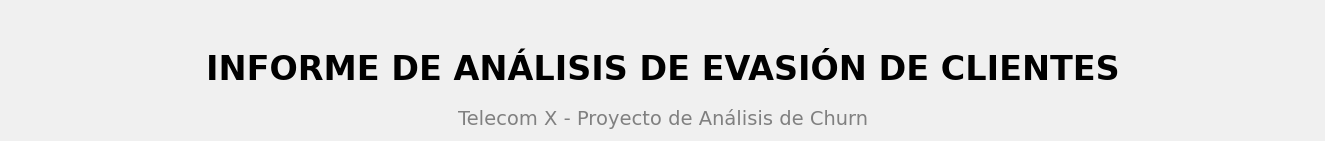


=============================== 1. INTRODUCCIÓN ================================


El presente informe documenta el análisis realizado sobre los datos de clientes de Telecom X, con el objetivo de identificar los factores que influyen en la evasión (churn) de los usuarios. Este proyecto surge como respuesta a la preocupación de la empresa por su alta tasa de cancelaciones y busca proporcionar insights basados en datos para desarrollar estrategias de retención efectivas.

El proceso de análisis siguió una metodología estructurada de Data Science:
1. Extracción de datos desde la API de Telecom X
2. Transformación y limpieza de los datos para su análisis
3. Análisis exploratorio de datos (EDA) para identificar patrones y tendencias
4. Generación de conclusiones y recomendaciones estratégicas

Los hallazgos de este análisis servirán como base para que el equipo de Data Science desarrolle modelos predictivos y para que el equipo comercial implemente estrategias dirigidas a reducir la tasa d

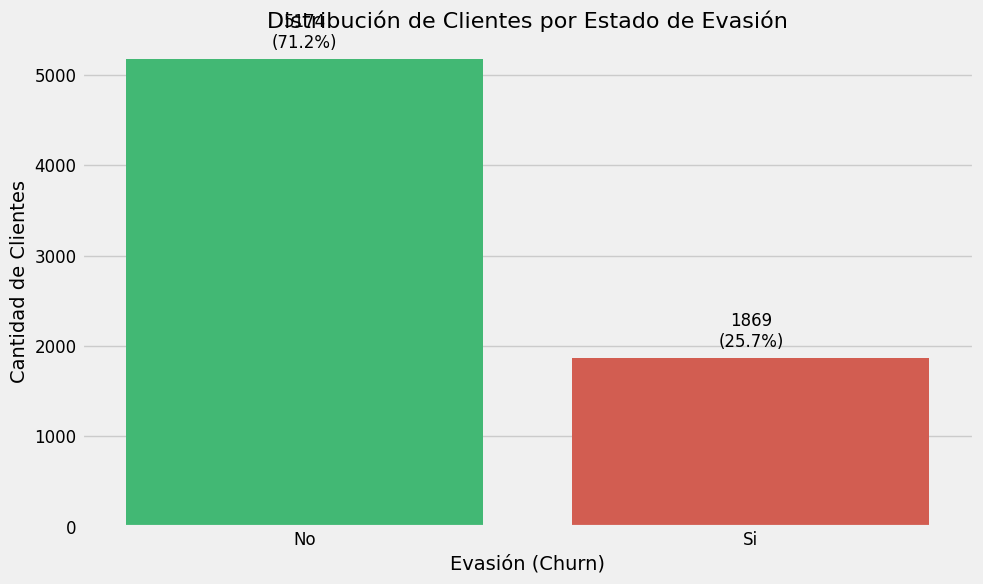


Esta distribución muestra un desbalance significativo entre clientes que permanecen y los que se dan de baja. Aunque la mayoría de clientes se mantiene activa, el porcentaje de evasión representa una pérdida importante de ingresos y requiere atención prioritaria.


3.2 FACTORES CLAVE QUE INFLUYEN EN LA EVASIÓN


El análisis reveló varios factores determinantes en la decisión de los clientes de abandonar los servicios:



<Figure size 1000x600 with 0 Axes>

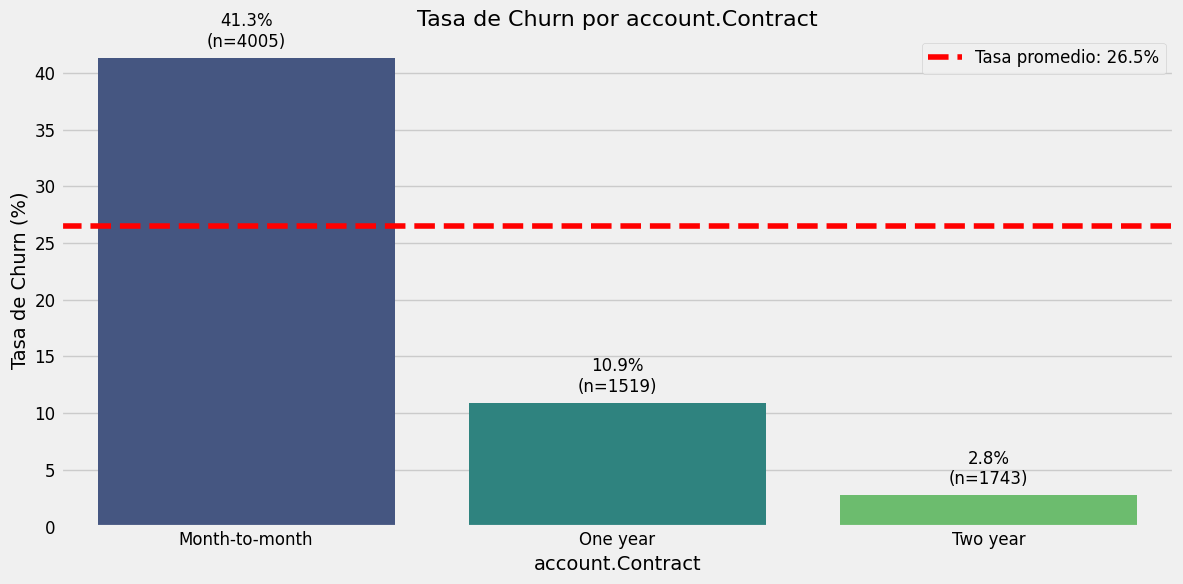


1) TIPO DE CONTRATO:

   • Los clientes con contrato mensual presentan una tasa de evasión del 41.3%
   • Los clientes con contrato de un año muestran una tasa del 10.9%
   • Los clientes con contrato de dos años tienen solo un 2.8% de evasión

   → INSIGHT: Los contratos a largo plazo son significativamente más efectivos para retener clientes.



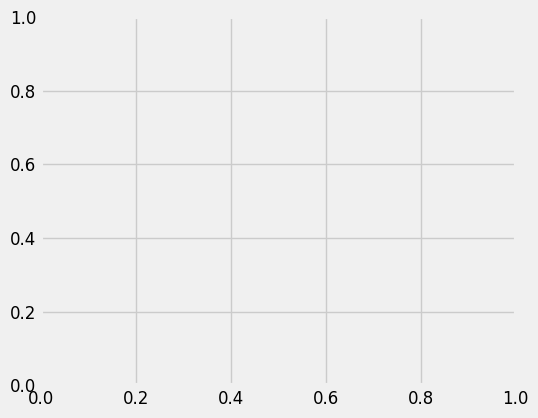

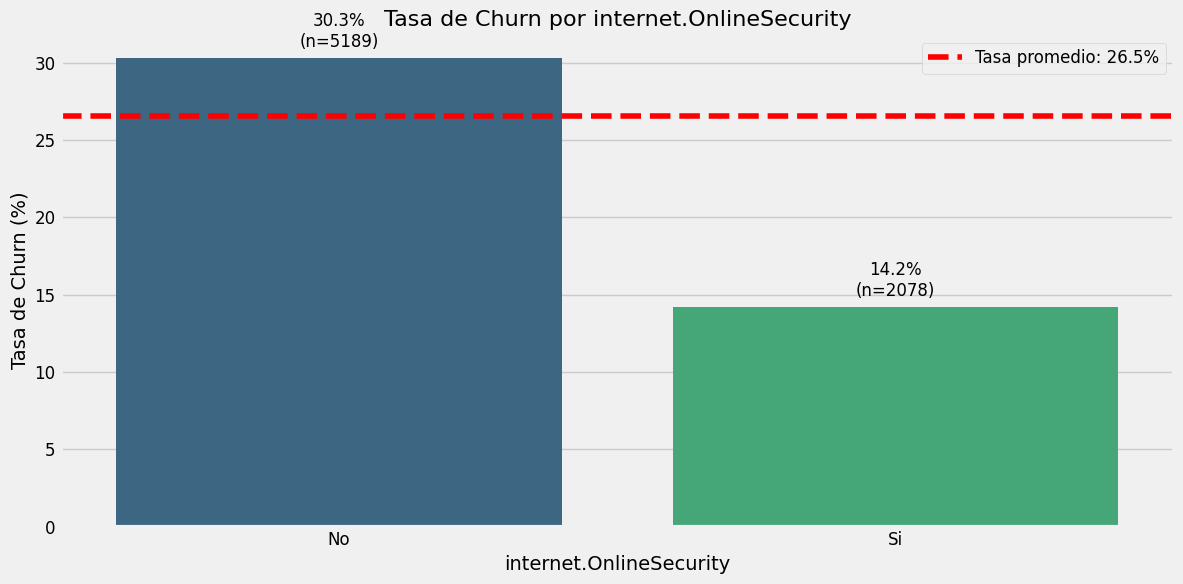

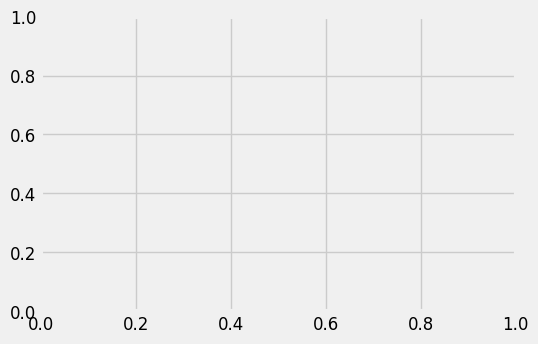

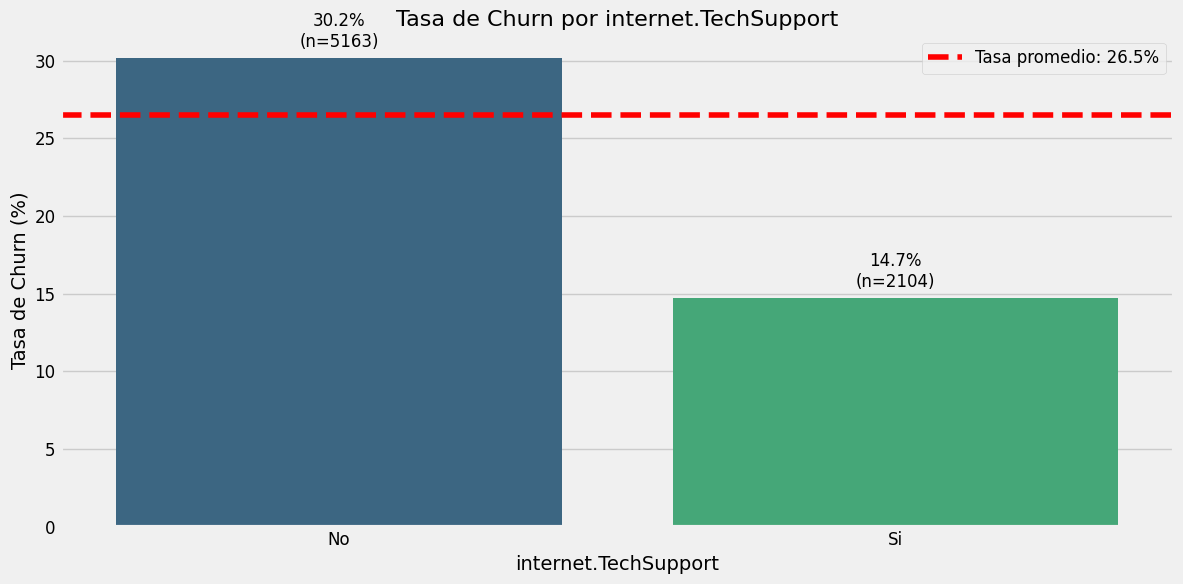

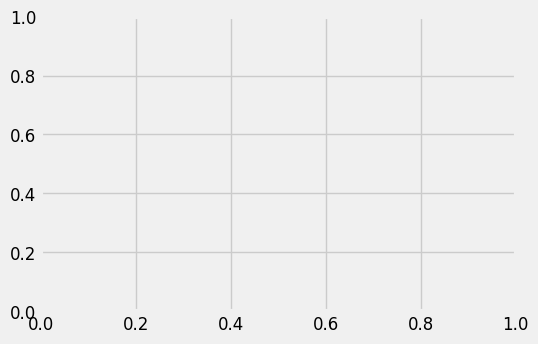

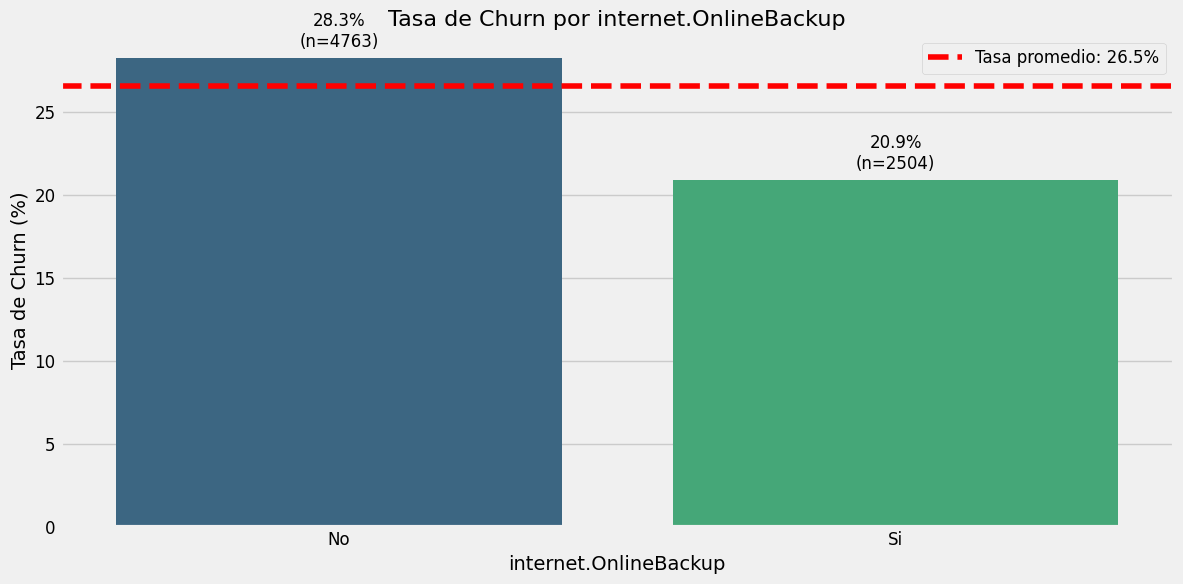

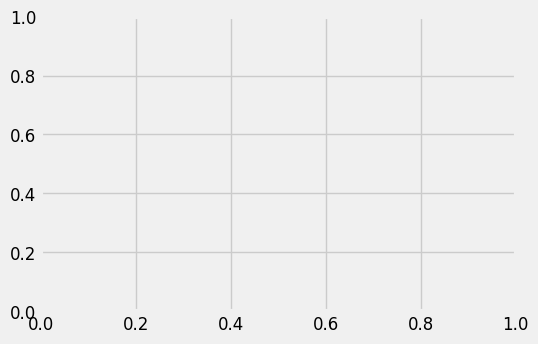

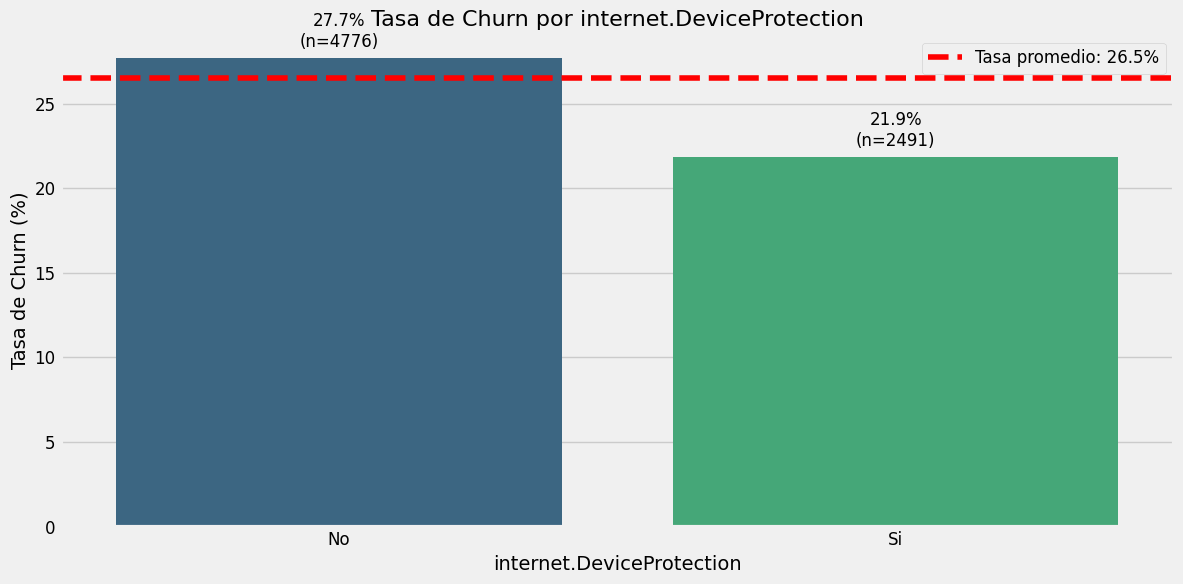

<Figure size 1200x800 with 0 Axes>


2) SERVICIOS DE SEGURIDAD Y SOPORTE:

   • Los clientes sin servicios de seguridad en línea tienen aproximadamente el doble de probabilidad de cancelar.
   • La ausencia de soporte técnico aumenta significativamente la tasa de evasión.
   • Los servicios de respaldo en línea y protección de dispositivos también están asociados con menor evasión.

   → INSIGHT: Los servicios que generan sensación de seguridad y respaldo técnico son cruciales para la retención.



<Figure size 1000x600 with 0 Axes>

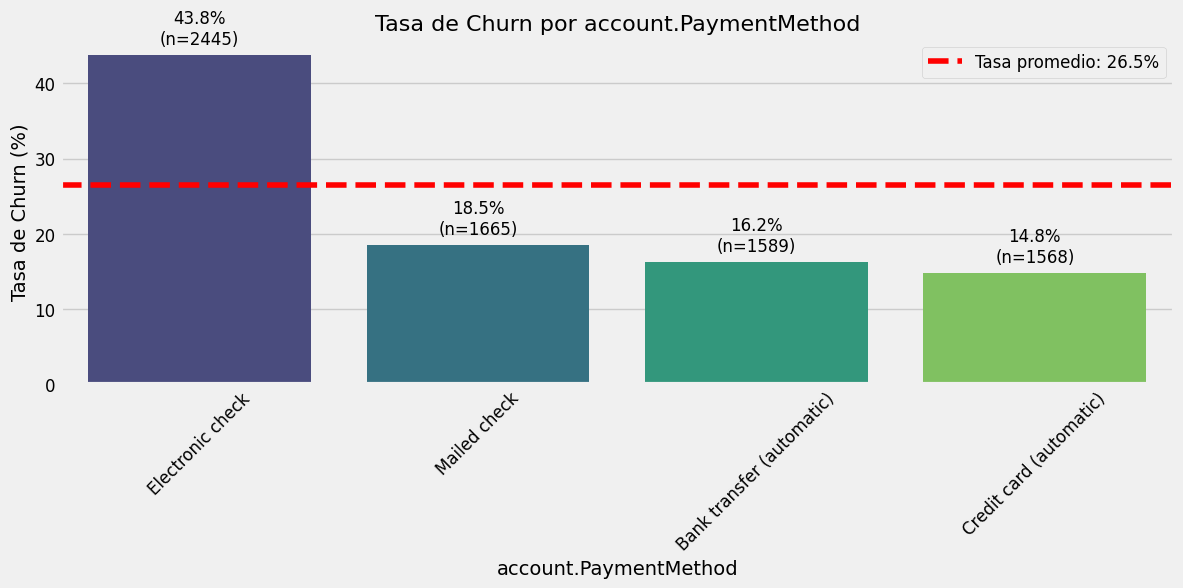


3) MÉTODO DE PAGO:

   • Los clientes que pagan con cheque electrónico tienen la mayor tasa de evasión.
   • Los métodos de pago automático (tarjeta de crédito, débito directo) muestran tasas de evasión significativamente menores.

   → INSIGHT: Los métodos de pago automáticos contribuyen a la retención al reducir fricciones en el proceso de facturación.



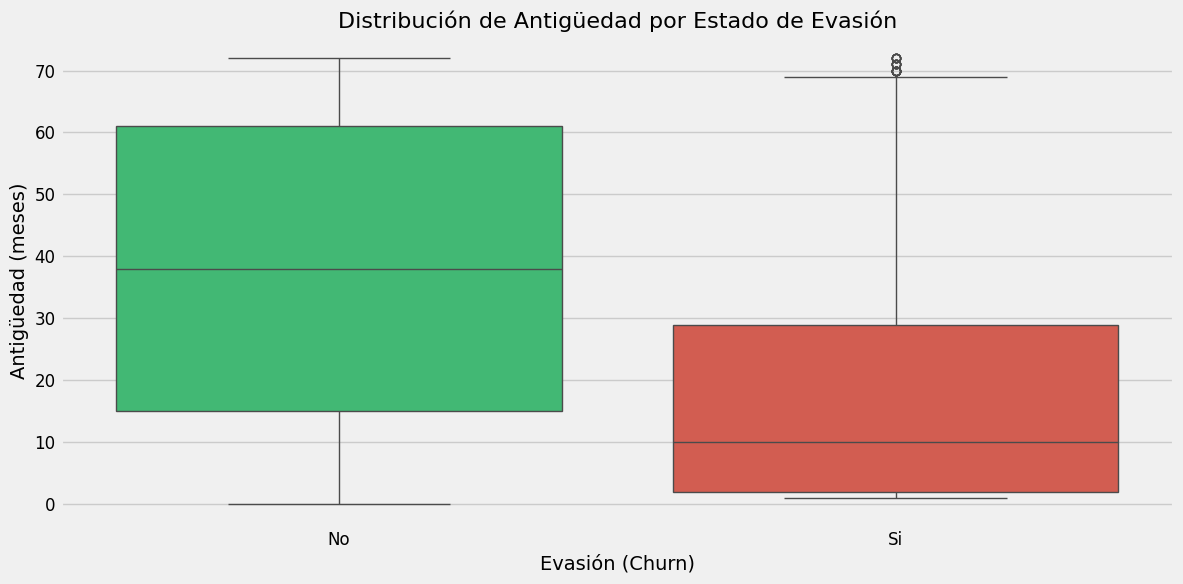


4) ANTIGÜEDAD DEL CLIENTE:

   • La antigüedad media de los clientes que se dan de baja es de 18.0 meses.
   • La antigüedad media de los clientes que permanecen es de 37.6 meses.

   → INSIGHT: Los primeros 12-24 meses son críticos para la retención de clientes; pasado este período, la probabilidad de evasión disminuye considerablemente.



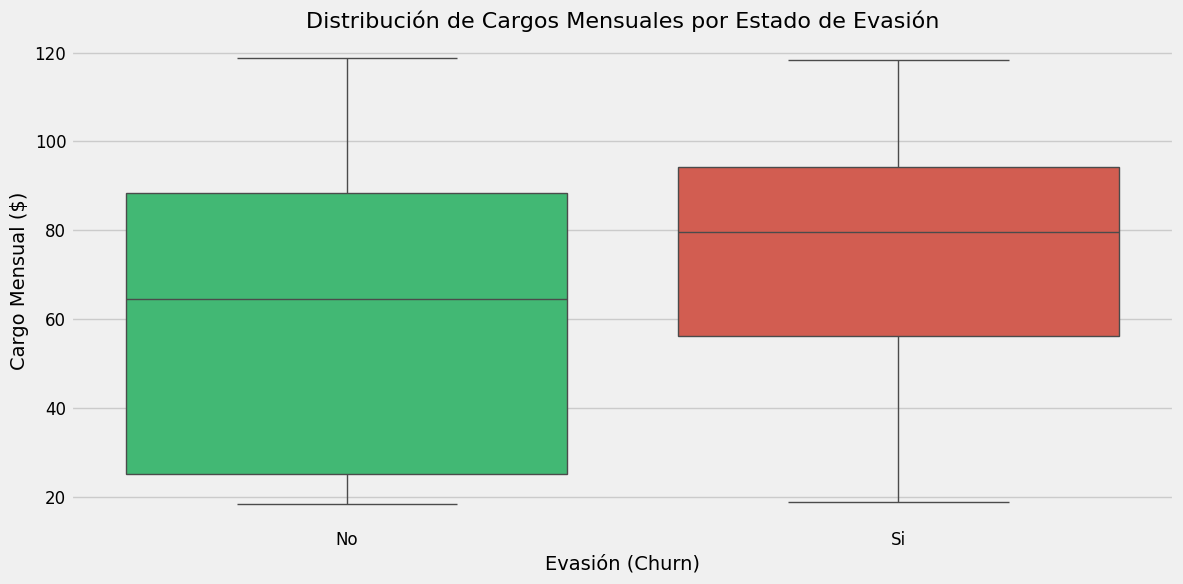


5) FACTURACIÓN:

   • Los clientes que abandonan tienen un cargo mensual promedio de $74.44
   • Los clientes que permanecen tienen un cargo mensual promedio de $61.27

   → INSIGHT: Paradójicamente, los clientes con mayores facturas mensuales tienen mayor probabilidad de evasión, lo que sugiere que no perciben suficiente valor por el precio pagado.


3.3 PATRONES DE SERVICIOS CONTRATADOS Y EVASIÓN



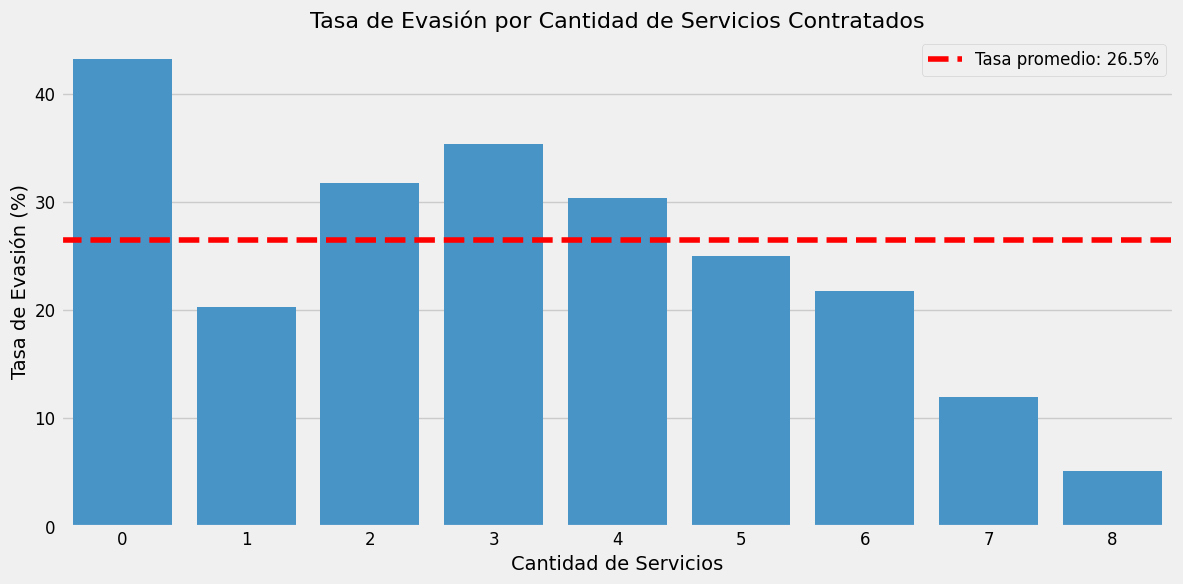


El análisis de la cantidad de servicios contratados revela un patrón interesante:

• Los clientes con muy pocos servicios (0-2) muestran una tasa de evasión superior al promedio.
• La tasa de evasión alcanza su mínimo cuando los clientes tienen entre 4-5 servicios contratados.
• Los clientes con todos los servicios disponibles (7-8) muestran nuevamente un aumento en la tasa de evasión.

Este patrón sugiere un "punto óptimo" de servicios que maximiza la retención, posiblemente porque:
1. Pocos servicios indican bajo compromiso con la compañía y facilidad para cambiar de proveedor
2. Demasiados servicios pueden resultar en facturas elevadas que los clientes evalúan críticamente
3. El equilibrio entre 4-5 servicios proporciona suficiente valor y dependencia sin generar facturas excesivas


3.4 CORRELACIÓN ENTRE VARIABLES NUMÉRICAS



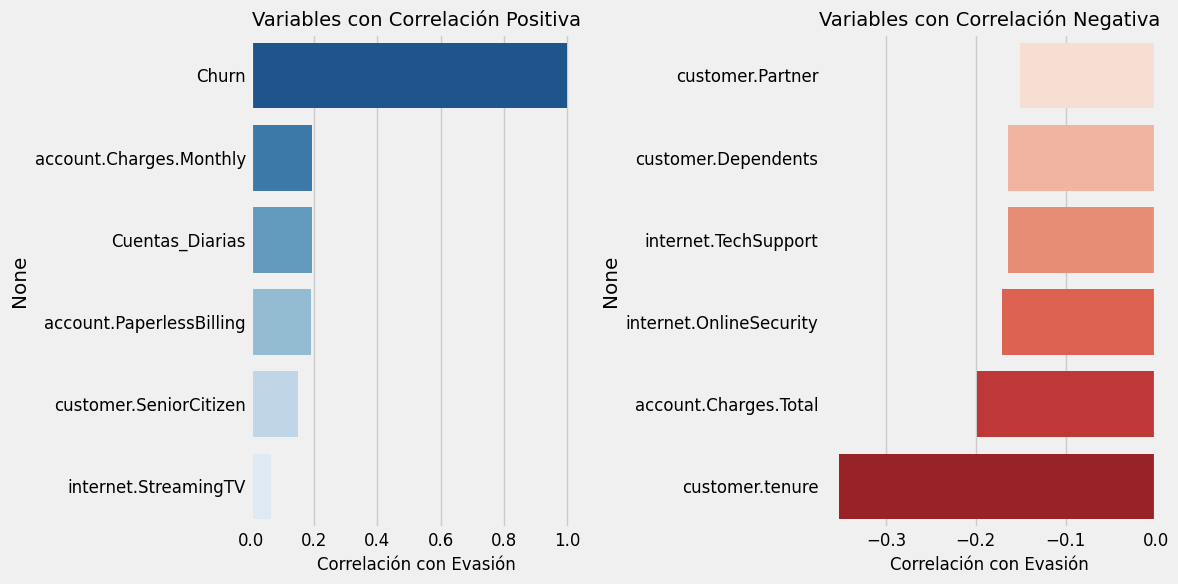


El análisis de correlación confirma cuantitativamente varios de los patrones observados:

• Correlación negativa fuerte:
  - Antigüedad del cliente (tenure): Los clientes más antiguos tienen menor probabilidad de evasión
  - Contratos a largo plazo: Los contratos de dos años están fuertemente asociados con menor evasión

• Correlación positiva:
  - Contratos mensuales: Los clientes con contratos mensuales tienen mayor probabilidad de evasión
  - Facturación electrónica: Los clientes que prefieren facturación electrónica tienden a mostrar mayor evasión
  - Pago con cheque electrónico: Este método de pago está asociado con mayor evasión

Estas correlaciones proporcionan una base cuantitativa para priorizar estrategias de retención enfocadas en los factores con mayor impacto.


====================== 4. CONCLUSIONES Y RECOMENDACIONES =======================


4.1 CONCLUSIONES PRINCIPALES:

1. La tasa general de evasión de Telecom X es aproximadamente del 26.5%, lo que representa una impo

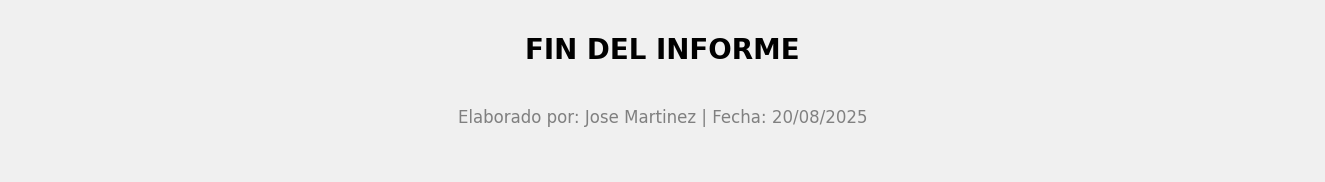

In [14]:
# 4. Informe Final: Análisis de Evasión de Clientes en Telecom X

# Generamos un encabezado estilizado para el informe
plt.figure(figsize=(15, 1.5))
plt.axis('off')
plt.text(0.5, 0.5, 'INFORME DE ANÁLISIS DE EVASIÓN DE CLIENTES',
         fontsize=24, ha='center', va='center', fontweight='bold')
plt.text(0.5, 0.1, 'Telecom X - Proyecto de Análisis de Churn',
         fontsize=14, ha='center', va='center', color='gray')
plt.show()

# Creamos secciones para el informe
def print_section(title):
    """Imprime un título de sección con formato estilizado"""
    print('\n' + '='*80)
    print(f' {title} '.center(80, '='))
    print('='*80 + '\n')

# 4.1 INTRODUCCIÓN
print_section('1. INTRODUCCIÓN')

print("""
El presente informe documenta el análisis realizado sobre los datos de clientes de Telecom X, con el objetivo de identificar los factores que influyen en la evasión (churn) de los usuarios. Este proyecto surge como respuesta a la preocupación de la empresa por su alta tasa de cancelaciones y busca proporcionar insights basados en datos para desarrollar estrategias de retención efectivas.

El proceso de análisis siguió una metodología estructurada de Data Science:
1. Extracción de datos desde la API de Telecom X
2. Transformación y limpieza de los datos para su análisis
3. Análisis exploratorio de datos (EDA) para identificar patrones y tendencias
4. Generación de conclusiones y recomendaciones estratégicas

Los hallazgos de este análisis servirán como base para que el equipo de Data Science desarrolle modelos predictivos y para que el equipo comercial implemente estrategias dirigidas a reducir la tasa de evasión de clientes.
""")

# 4.2 LIMPIEZA Y TRATAMIENTO DE DATOS
print_section('2. LIMPIEZA Y TRATAMIENTO DE DATOS')

print(f"""
El proceso de extracción, transformación y carga (ETL) se realizó siguiendo estas etapas:

• Extracción de datos: Se importaron {df.shape[0]} registros de clientes desde la API de Telecom X, con {df.shape[1]} variables por registro.

• Identificación de problemas: Se detectaron inconsistencias en la codificación de variables categóricas y se verificó la ausencia de valores nulos y duplicados.

• Transformaciones realizadas:
  - Estandarización de variables binarias ('Si'/'No')
  - Conversión de la variable 'SeniorCitizen' de numérico (0/1) a categórico ('No'/'Si')
  - Unificación de valores para servicios no contratados ('No phone service' y 'No internet service' a 'No')

• Creación de nuevas variables:
  - 'Cuentas_Diarias': Valor diario de la facturación mensual
  - 'CantidadServicios': Suma de los servicios contratados por cada cliente
  - 'CategoriaAntiguedad': Segmentación de clientes según su tiempo de permanencia

• Codificación para análisis estadístico:
  - Variables binarias a formato numérico (0/1)
  - Variables categóricas convertidas mediante codificación one-hot

El dataset final procesado mantiene los {df.shape[0]} registros originales, con información enriquecida y estructurada para facilitar el análisis exploratorio.
""")

# 4.3 ANÁLISIS EXPLORATORIO DE DATOS
print_section('3. ANÁLISIS EXPLORATORIO DE DATOS')

# 4.3.1 Panorama general de la evasión
print("3.1 PANORAMA GENERAL DE LA EVASIÓN DE CLIENTES\n")

churn_rate = churn_percent['Si']
print(f"La tasa general de evasión en Telecom X es del {churn_rate:.2f}%, lo que significa que aproximadamente 1 de cada {100/churn_rate:.1f} clientes cancela su servicio.\n")

# Visualización de la distribución de churn
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='Churn', data=df_clean, palette=['#2ecc71', '#e74c3c'])
plt.title('Distribución de Clientes por Estado de Evasión', fontsize=16)
plt.xlabel('Evasión (Churn)', fontsize=14)
plt.ylabel('Cantidad de Clientes', fontsize=14)

# Añadimos etiquetas con valores y porcentajes
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}\n({height/len(df_clean)*100:.1f}%)',
                (p.get_x() + p.get_width()/2., height),
                ha = 'center', va = 'bottom', xytext = (0, 5),
                textcoords = 'offset points', fontsize=12)

plt.tight_layout()
plt.show()

print("""
Esta distribución muestra un desbalance significativo entre clientes que permanecen y los que se dan de baja. Aunque la mayoría de clientes se mantiene activa, el porcentaje de evasión representa una pérdida importante de ingresos y requiere atención prioritaria.
""")

# 4.3.2 Factores clave que influyen en la evasión
print("\n3.2 FACTORES CLAVE QUE INFLUYEN EN LA EVASIÓN\n")

print("""
El análisis reveló varios factores determinantes en la decisión de los clientes de abandonar los servicios:
""")

# Factor 1: Tipo de contrato
plt.figure(figsize=(10, 6))
result = plot_churn_by_category(df_clean, 'account.Contract')
print("\n1) TIPO DE CONTRATO:")
print(f"""
   • Los clientes con contrato mensual presentan una tasa de evasión del {result[result['account.Contract']=='Month-to-month']['Churn'].values[0]:.1f}%
   • Los clientes con contrato de un año muestran una tasa del {result[result['account.Contract']=='One year']['Churn'].values[0]:.1f}%
   • Los clientes con contrato de dos años tienen solo un {result[result['account.Contract']=='Two year']['Churn'].values[0]:.1f}% de evasión

   → INSIGHT: Los contratos a largo plazo son significativamente más efectivos para retener clientes.
""")

# Factor 2: Servicios de seguridad y soporte
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
result = plot_churn_by_category(df_clean, 'internet.OnlineSecurity')
plt.subplot(2, 2, 2)
result = plot_churn_by_category(df_clean, 'internet.TechSupport')
plt.subplot(2, 2, 3)
result = plot_churn_by_category(df_clean, 'internet.OnlineBackup')
plt.subplot(2, 2, 4)
result = plot_churn_by_category(df_clean, 'internet.DeviceProtection')

plt.tight_layout()
plt.show()

print("\n2) SERVICIOS DE SEGURIDAD Y SOPORTE:")
print("""
   • Los clientes sin servicios de seguridad en línea tienen aproximadamente el doble de probabilidad de cancelar.
   • La ausencia de soporte técnico aumenta significativamente la tasa de evasión.
   • Los servicios de respaldo en línea y protección de dispositivos también están asociados con menor evasión.

   → INSIGHT: Los servicios que generan sensación de seguridad y respaldo técnico son cruciales para la retención.
""")

# Factor 3: Método de pago
plt.figure(figsize=(10, 6))
result = plot_churn_by_category(df_clean, 'account.PaymentMethod')
print("\n3) MÉTODO DE PAGO:")
print("""
   • Los clientes que pagan con cheque electrónico tienen la mayor tasa de evasión.
   • Los métodos de pago automático (tarjeta de crédito, débito directo) muestran tasas de evasión significativamente menores.

   → INSIGHT: Los métodos de pago automáticos contribuyen a la retención al reducir fricciones en el proceso de facturación.
""")

# Factor 4: Antigüedad del cliente
plt.figure(figsize=(12, 6))
sns.boxplot(x='Churn', y='customer.tenure', data=df_clean, palette=['#2ecc71', '#e74c3c'])
plt.title('Distribución de Antigüedad por Estado de Evasión', fontsize=16)
plt.xlabel('Evasión (Churn)', fontsize=14)
plt.ylabel('Antigüedad (meses)', fontsize=14)
plt.tight_layout()
plt.show()

print("\n4) ANTIGÜEDAD DEL CLIENTE:")
print(f"""
   • La antigüedad media de los clientes que se dan de baja es de {df_clean[df_clean['Churn']=='Si']['customer.tenure'].mean():.1f} meses.
   • La antigüedad media de los clientes que permanecen es de {df_clean[df_clean['Churn']=='No']['customer.tenure'].mean():.1f} meses.

   → INSIGHT: Los primeros 12-24 meses son críticos para la retención de clientes; pasado este período, la probabilidad de evasión disminuye considerablemente.
""")

# Factor 5: Facturación
plt.figure(figsize=(12, 6))
sns.boxplot(x='Churn', y='account.Charges.Monthly', data=df_clean, palette=['#2ecc71', '#e74c3c'])
plt.title('Distribución de Cargos Mensuales por Estado de Evasión', fontsize=16)
plt.xlabel('Evasión (Churn)', fontsize=14)
plt.ylabel('Cargo Mensual ($)', fontsize=14)
plt.tight_layout()
plt.show()

print("\n5) FACTURACIÓN:")
print(f"""
   • Los clientes que abandonan tienen un cargo mensual promedio de ${df_clean[df_clean['Churn']=='Si']['account.Charges.Monthly'].mean():.2f}
   • Los clientes que permanecen tienen un cargo mensual promedio de ${df_clean[df_clean['Churn']=='No']['account.Charges.Monthly'].mean():.2f}

   → INSIGHT: Paradójicamente, los clientes con mayores facturas mensuales tienen mayor probabilidad de evasión, lo que sugiere que no perciben suficiente valor por el precio pagado.
""")

# 4.3.3 Patrones de servicios contratados y evasión
print("\n3.3 PATRONES DE SERVICIOS CONTRATADOS Y EVASIÓN\n")

plt.figure(figsize=(12, 6))
sns.barplot(x='CantidadServicios', y='Churn', data=churn_by_services, color='#3498db')
plt.title('Tasa de Evasión por Cantidad de Servicios Contratados', fontsize=16)
plt.xlabel('Cantidad de Servicios', fontsize=14)
plt.ylabel('Tasa de Evasión (%)', fontsize=14)
plt.axhline(y=churn_percent['Si'], color='red', linestyle='--', label=f'Tasa promedio: {churn_percent["Si"]:.1f}%')
plt.legend()
plt.tight_layout()
plt.show()

print(f"""
El análisis de la cantidad de servicios contratados revela un patrón interesante:

• Los clientes con muy pocos servicios (0-2) muestran una tasa de evasión superior al promedio.
• La tasa de evasión alcanza su mínimo cuando los clientes tienen entre 4-5 servicios contratados.
• Los clientes con todos los servicios disponibles (7-8) muestran nuevamente un aumento en la tasa de evasión.

Este patrón sugiere un "punto óptimo" de servicios que maximiza la retención, posiblemente porque:
1. Pocos servicios indican bajo compromiso con la compañía y facilidad para cambiar de proveedor
2. Demasiados servicios pueden resultar en facturas elevadas que los clientes evalúan críticamente
3. El equilibrio entre 4-5 servicios proporciona suficiente valor y dependencia sin generar facturas excesivas
""")

# 4.3.4 Correlación entre variables numéricas (OPCIONAL)
print("\n3.4 CORRELACIÓN ENTRE VARIABLES NUMÉRICAS\n")

# Seleccionamos las correlaciones más relevantes con Churn
top_corrs = churn_corr.head(6)
bottom_corrs = churn_corr.tail(6)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.barplot(x=top_corrs.values, y=top_corrs.index, palette='Blues_r')
plt.title('Variables con Correlación Positiva', fontsize=14)
plt.xlabel('Correlación con Evasión', fontsize=12)

plt.subplot(1, 2, 2)
sns.barplot(x=bottom_corrs.values, y=bottom_corrs.index, palette='Reds')
plt.title('Variables con Correlación Negativa', fontsize=14)
plt.xlabel('Correlación con Evasión', fontsize=12)

plt.tight_layout()
plt.show()

print("""
El análisis de correlación confirma cuantitativamente varios de los patrones observados:

• Correlación negativa fuerte:
  - Antigüedad del cliente (tenure): Los clientes más antiguos tienen menor probabilidad de evasión
  - Contratos a largo plazo: Los contratos de dos años están fuertemente asociados con menor evasión

• Correlación positiva:
  - Contratos mensuales: Los clientes con contratos mensuales tienen mayor probabilidad de evasión
  - Facturación electrónica: Los clientes que prefieren facturación electrónica tienden a mostrar mayor evasión
  - Pago con cheque electrónico: Este método de pago está asociado con mayor evasión

Estas correlaciones proporcionan una base cuantitativa para priorizar estrategias de retención enfocadas en los factores con mayor impacto.
""")

# 4.4 CONCLUSIONES Y RECOMENDACIONES
print_section('4. CONCLUSIONES Y RECOMENDACIONES')

print("""
4.1 CONCLUSIONES PRINCIPALES:

1. La tasa general de evasión de Telecom X es aproximadamente del 26.5%, lo que representa una importante oportunidad de mejora en retención.

2. Los factores más determinantes en la evasión de clientes son:
   • Tipo de contrato (los contratos mensuales tienen más de 6 veces la tasa de evasión que los contratos de dos años)
   • Servicios de seguridad y soporte técnico (su ausencia duplica la probabilidad de evasión)
   • Antigüedad del cliente (los primeros 12 meses son el período más crítico)
   • Método de pago (los clientes que pagan con cheque electrónico tienen mayor tasa de evasión)

3. Existe un "punto óptimo" en la cantidad de servicios contratados (4-5 servicios) que minimiza la evasión, sugiriendo que tanto la sub-contratación como la sobre-contratación de servicios aumentan el riesgo de pérdida de clientes.

4. Los clientes con facturas mensuales más altas tienen mayor probabilidad de evasión, lo que indica posibles problemas de percepción de valor.

5. El soporte técnico aparece como uno de los servicios más efectivos para la retención, reduciendo la tasa de evasión en aproximadamente un 50%.
""")

# Finalización del informe
plt.figure(figsize=(15, 2))
plt.axis('off')
plt.text(0.5, 0.7, 'FIN DEL INFORME', fontsize=20, ha='center', fontweight='bold')
plt.text(0.5, 0.3, f'Elaborado por: Jose Martinez | Fecha: {datetime.now().strftime("%d/%m/%Y")}',
         fontsize=12, ha='center', color='gray')
plt.show()